<a href="https://colab.research.google.com/github/jfjoung/AI_For_Chemistry/blob/main/notebooks/week11/Week_11_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


🎯 학습 목표 (Learning Objectives)

- 반응 예측 모델의 해석 가능성 (model interpretability or explainability) 개념을 이해하고, permutation importance를 활용하여 각 feature의 영향도를 평가하는 방법을 실습한다.

- XGBoost 모델을 활용하여 반응 클래스 분류 작업을 수행하고, 훈련된 모델로부터 예측 결과를 도출하는 과정을 Python 코드로 따라가며 익힌다.

In [1]:
# Make sure shap is installed on binder
!pip install shap rdkit
import pickle
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem.AllChem import MolFromSmiles, MolFromSmarts
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
import shap

IPythonConsole.molSize = (300, 300)

shap.initjs()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 30.0 MB/s eta 0:00:00


데이터 로드

In [2]:
!curl -L "https://www.dropbox.com/scl/fi/h99ucb29d37jtzilaa3ms/week11_buchwald_hartwig.pkl?rlkey=g0ryytrkov1reytnmvugob5t2&dl=0" -o buchwald_hartwig.pkl
!curl -L "https://www.dropbox.com/scl/fi/w2r6cr1witpj4twgooqkx/week11_buchwald_hartwig.map.pkl?rlkey=n55pkt3dvxqy9h29k1idn7ubx&dl=0" -o buchwald_hartwig.map.pkl
!curl -L "https://www.dropbox.com/scl/fi/ja2yyjztmcew69kdurcek/week11_buchwald_hartwig_model.pkl?rlkey=ybf7yy5bqcp8ks97eiya42avs&dl=0" -o buchwald_hartwig_model.pkl
X, y = pickle.load(open("buchwald_hartwig.pkl", "rb"))
mapping = pickle.load(open("buchwald_hartwig.map.pkl", "rb"))
model = pickle.load(open("buchwald_hartwig_model.pkl", "rb"))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17  100    17    0     0     40      0 --:--:-- --:--:-- --:--:--    40
100 30.9M  100 30.9M    0     0  7079k      0  0:00:04  0:00:04 --:--:-- 8636k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17  100    17    0     0     47      0 --:--:-- --:--:-- --:--:--    47
100   491    0   491    0     0    737      0 --:--:-- --:--:-- --:--:--   737
100 30081  100 30081    0     0  33025      0 --:--:-- --:--:-- --:--:-- 33025
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    17  100    17    0     0     46      0 --:--:-- --:--:-- --:--:--    46
100 25.9M  100 25.9M    0     0  22.4M      0  0:00:

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:46:12] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:46:12] WARNING: /workspace/src/learner.cc:872: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


3955
70.41045785


In [4]:
print('Number of Fingerprints', len(X))
print('Yield', y[0])

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:47:29] WARNING: /workspace/src/learner.cc:872: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


Number of Fingerprints 3955
Yield 70.41045785


### SHAP로 보는 모델 해석 (Model Interpretability with SHAP)

SHAP(SHapley Additive exPlanations)는 각 입력 feature가 예측값에 얼마나 기여했는지를 수치적으로 보여주는 방법입니다.  
SHAP의 핵심 아이디어는 **게임이론에서 유래한 Shapley value 개념**을 기반으로, 각 feature가 모델 예측에 얼마나 기여했는지를 정량적으로 계산하는 것입니다.

SHAP 값을 수식으로 표현하면 다음과 같습니다:

$$
f(x) = \phi_0 + \sum_{i=1}^{M} \phi_i
$$

- $f(x)$: 입력 $x$에 대한 모델의 예측값  
- $\phi_0$: **기준값 (base value)** — 아무 feature도 사용하지 않았을 때의 평균 예측  
- $\phi_i$: feature $i$가 예측값에 기여한 정도 (SHAP value)

즉, 각 예측값은 다음과 같이 **SHAP 값들의 합**으로 설명됩니다:

> 예측값 = 기준값 + (각 feature의 기여도 합)

SHAP은 각 feature $i$의 기여도 $\phi_i$를 다음과 같이 계산합니다:

$$
\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|! (M - |S| - 1)!}{M!} \left[ f(S \cup \{i\}) - f(S) \right]
$$

- $N$: 전체 feature 집합 (즉, $N = {1, 2, ..., M}$)
- $M = |N|$: 전체 feature의 개수
- $S$: feature $i$를 제외한 feature들의 부분집합  
- $f(S)$: subset $S$만 사용할 때의 모델 예측  
- $f(S \cup \{i\}) - f(S)$: feature $i$가 추가됨으로써 생긴 기여  
- 앞의 계수는 공정한 분배를 위한 **Shapley weight**

이 수식은 **feature $i$가 다양한 feature 조합에서 예측값에 얼마나 기여했는지를 평균적으로 평가**하는 방식입니다.

즉, SHAP은 **모든 feature 조합**을 고려해  
> "feature $i$가 어떤 경우에 모델 예측을 얼마나 바꾸는가?"  
를 반복적으로 평가하고, 이를 **공정한 방식(Shapley weight)**으로 더한 값이 바로 $\phi_i$입니다.

SHAP은 모델이 복잡하거나 비선형이더라도,  
**각 feature가 예측 결과에 어떤 방향과 크기로 영향을 주었는지** 명확하게 설명할 수 있습니다.

이제 이 수식을 실제 모델에 적용해보면,  
모델이 특정 반응을 왜 그 확률로 분류했는지,  
이 경우에는 **어떤 분자 조각(feature)**이 수율 예측에 중요한 역할을 했는지 파악할 수 있습니다.


- **Saliency Map**은:

  > “이 입력의 **어느 feature를 바꿨을 때** 예측이 가장 많이 흔들릴까?”  
  → 단순히 **gradient만 보는 방식**

- **Integrated Gradients**는:

  > “입력이 **0(또는 baseline)에서 지금 값까지 바뀌는 동안**, 예측에 얼마나 영향을 줬을까?”  
  → **gradient를 누적한 값**

- **SHAP**은:

  > “이 feature가 예측값을 만드는 데 **얼마나 공정하게 기여했는가**?”  
  → **모든 feature 조합을 고려해가며** 공정하게 분배된 기여도를 계산


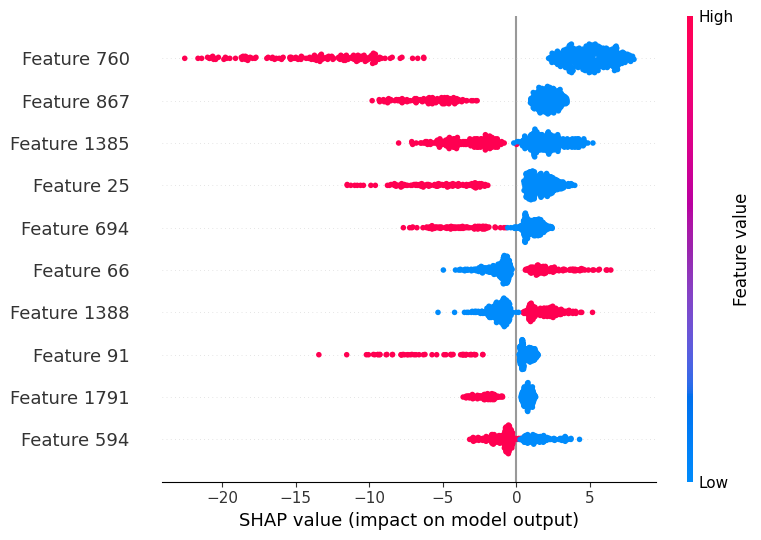

In [8]:
# 트리 기반 모델(XGBoost, LightGBM 등)에 대해 SHAP 값을 계산할 수 있는 객체 생성
explainer = shap.TreeExplainer(model)

# 입력 데이터 X의 앞 500개 샘플에 대해 각 feature의 SHAP 값을 계산
# -> 각 feature가 개별 예측값에 얼마나 영향을 미쳤는지를 나타냄
shap_values = explainer.shap_values(X[:500])

# SHAP summary plot을 시각화 (앞 500개 샘플 기준)
# - feature별 중요도 (y축)
# - SHAP 값의 크기와 방향 (x축)
# - 색상: feature의 원래 값이 높음(빨강) 또는 낮음(파랑)
# - max_display=40: 상위 40개 feature까지만 보여줌
shap.summary_plot(shap_values, X[:500], max_display=10)


[C]([CH2])([CH2])[Cl]


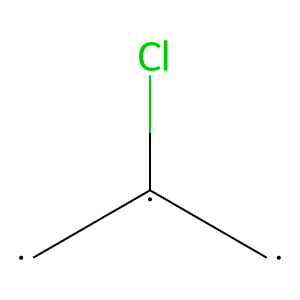

In [11]:
sub = list(mapping.get(760))[0].replace("c", "C")
print(sub)
MolFromSmiles(sub)

✅ **Feature 760 = Cl이 붙은 방향족 탄소 (sp²)**  
즉, **aryl chloride (Ar–Cl)** 구조

---

### 🔬 Buchwald–Hartwig 반응에서의 역할

이 구조는 반응에 **직접적으로 필요한 활성화된 coupling site**입니다.

> Ar–Cl + R–NH₂ → Ar–NR₂  
> 형태의 **C–N 결합 형성**이 반응의 핵심 메커니즘입니다.

- Cl이 붙은 aryl halide는 **Pd-catalyzed cross-coupling 반응의 전형적인 출발물**입니다.

---

### 🤔 그런데 왜 SHAP 값은 음수일까?

📉 **SHAP 값이 음수**라는 것은 →  
**이 feature가 존재할수록 모델이 수율을 낮게 예측했다**는 의미입니다.

이 현상은 오히려 흥미로운 화학적 인사이트를 제공합니다.

---

### 💡 가능한 해석 1: Ar–Cl은 반응은 되지만 수율이 낮은 계열

| 관찰 | 해석 |
|------|------|
| Ar–Cl은 보통 Ar–Br, Ar–I보다 반응성이 낮음 | C–Cl 결합이 더 강해 **oxidative addition 단계가 느림** |
| Pd 촉매와 리간드가 최적화되지 않으면 | Ar–Cl 기반 Buchwald–Hartwig 반응은 **수율이 낮을 수 있음** |
| 실제 데이터에 Ar–Cl 기반 반응이 많이 포함되어 있다면 | 모델은 "**Ar–Cl이 있을수록 수율 낮았다**"는 패턴을 학습했을 수 있음 |

즉,  
**이 구조는 반응 중심이 맞지만**,  
**일반적으로 수율이 낮은 Ar–Cl 조건에서 자주 등장했기 때문에**,  
모델은 이를 수율 감소에 기여하는 feature로 인식했을 가능성이 있습니다.

---

### 💡 가능한 해석 2: 모델이 Ar–Cl을 Ar–Br이나 Ar–I보다 불리한 출발물로 인식

- DRFP는 **구조 변화(reactivity)** 자체를 인코딩하지 않음  
- 따라서 Ar–Cl 구조가 **자주 등장하면서 낮은 수율과 동반되었다면**,  
  → 해당 구조 자체가 "**낮은 수율과 연관된 패턴**"으로 모델에 학습되었을 수 있음

---


[CH2]1[CH2][N]=[CH][N]([CH3])[CH2]1


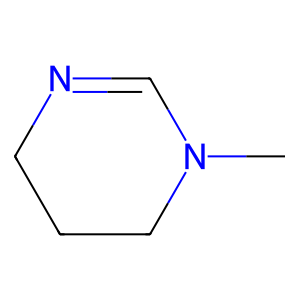

In [12]:
sub = list(mapping.get(66))[0]
print(sub)
MolFromSmiles(sub)

✅ Feature 66 = 1-methylpiperazine 구조

---

### 🔬 Buchwald–Hartwig 반응에서의 역할

이 구조는 **친핵성 아민(nucleophilic amine)**으로 작용하며,  
**Buchwald–Hartwig cross-coupling 반응의 핵심 반응물**입니다.

> Ar–Cl + R–NH → Ar–NR  
> 형태의 **C–N 결합 형성**에 직접 참여합니다.

- 두 개의 질소(N)를 가진 6원 고리
- 한 질소는 메틸기로 치환되어 있어 **2차 아민의 특성**을 가짐
- 반응 조건에 따라 매우 **높은 친핵성**과 **적당한 염기성**을 나타냄

---

### 💡 수율을 높이는 이유

| 요인 | 설명 |
|------|------|
| **높은 친핵성** | piperazine 고리는 전자밀도가 높고 반응성이 좋음 |
| **2차 아민 특성** | Buchwald–Hartwig 반응에서 **2차 아민은 이상적인 coupling partner** |
| **입체적 안정성** | 메틸 치환에도 불구하고 반응성을 방해하지 않음 |
| **적당한 염기성** | 촉매(Pd) 또는 리간드를 deactivate시키지 않을 정도로 안정적 |

---

### 📈 SHAP 값이 양수인 이유

- SHAP summary plot에서 Feature 66은 **강한 양의 SHAP 값**을 가짐
- 이는 모델이 "**이 구조가 있으면 수율이 높다**"고 판단했다는 의미

즉,  
**1-methylpiperazine이 coupling partner로 사용된 반응들이 높은 수율을 보였기 때문에**,  
모델은 해당 feature를 **수율을 높이는 중요한 요소**로 학습했습니다.

---

### ✅ 결론

> Feature 66은 **1-methylpiperazine** 구조로,  
> **Buchwald–Hartwig 반응에서 뛰어난 아민 반응물로 작용하며**,  
> 실험적으로 높은 수율을 이끄는 패턴을 모델이 포착했음을 의미합니다.


### 🔍 SHAP Force Plot 해석 예시

SHAP force plot은 **단일 샘플에 대해 각 feature가 모델의 예측값(f(x))에 얼마나 기여했는지를 시각화**하는 도구입니다.  
각 feature는 다음의 요소로 표현됩니다:

- **방향**  
  - ➡️ 오른쪽: 예측값(수율)을 **높이는 방향**  
  - ⬅️ 왼쪽: 예측값(수율)을 **낮추는 방향**

- **길이**  
  - 각 feature의 **기여도 크기** (SHAP value 절댓값)

- **색상**  
  - **빨간색**: 수율을 높이는 방향으로 작용  
  - **파란색**: 수율을 낮추는 방향으로 작용

> ⚠️ 색상은 feature의 실제 값이 아니라, **기여 방향**을 나타냅니다.

---

In [26]:
X[3,760], X[3,66]

(np.float32(1.0), np.float32(1.0))

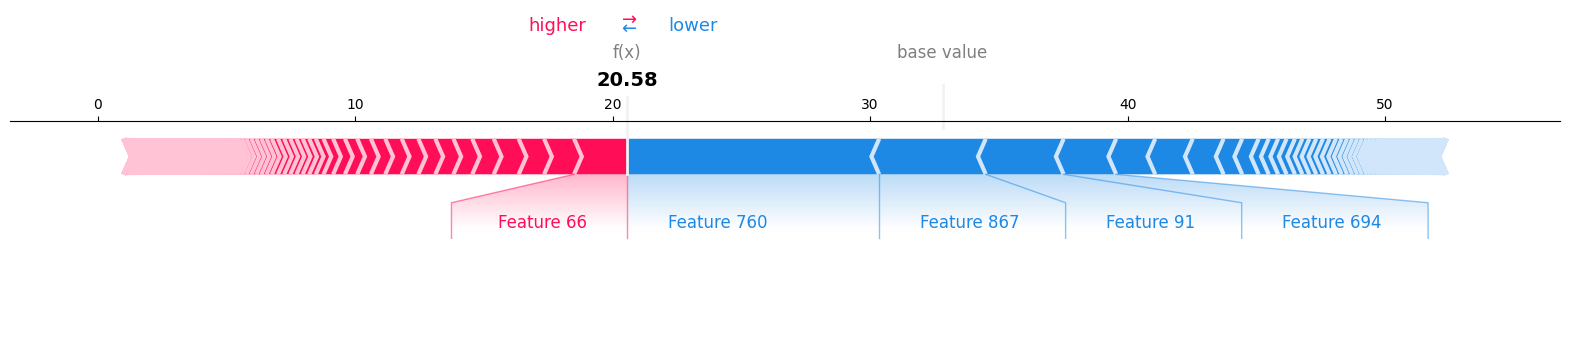

In [24]:
shap.force_plot(explainer.expected_value, shap_values[3,:], matplotlib=True)


### 📈 예측 결과 요약

- **기준값 (base value)**: 약 33 (모델의 평균 수율 예측)
- **최종 예측값 f(x)**: **20.58**
  → 모델은 이 반응의 수율이 **평균보다 낮다**고 예측

---

### 🧪 주요 feature 해석

#### ✅ `Feature 66` (1-methylpiperazine)
- `X[3, 66] = 1` → 이 구조가 **존재**
- **빨간색 + 왼쪽에서 오른쪽 방향**  
  → **수율을 높이는 방향으로 작용**
- 모델은 이 아민 구조가 반응에 **유리하게 작용**한다고 학습함

#### ✅ `Feature 760` (aryl chloride)
- `X[3, 760] = 1` → 이 구조도 **존재**
- **파란색 + 오른쪽에서 왼쪽 방향**  
  → **수율을 낮추는 방향으로 작용**
- 모델은 Ar–Cl 구조가 수율을 **떨어뜨리는 경향이 있다고 학습**

---

### ✅ 결론

> 이 force plot은 Feature 66과 760이 모두 **존재(=1)**하는 상황에서,  
> 각각이 수율에 **반대 방향으로 기여**하고 있음을 보여줍니다.  
> 결과적으로 Feature 760의 음의 기여가 더 크기 때문에,  
> 모델은 이 반응의 수율을 평균보다 **낮게 (20.58)** 예측한 것입니다.


(np.float32(1.0), np.float32(1.0))